# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

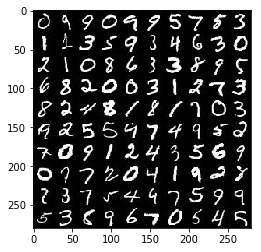

In [2]:
show_n_images = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

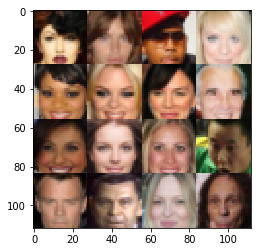

In [3]:
show_n_images = 20

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(dtype=tf.float32, shape=(None,image_width,image_height,image_channels))
    z_input = tf.placeholder(dtype=tf.float32, shape=(None,z_dim))
    learning_rate = tf.placeholder(dtype=tf.float32)

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 16x16x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True, )
        relu2 = tf.nn.relu(bn2)
        relu2 = tf.nn.dropout(relu2, keep_prob=0.8)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.nn.relu(bn3)
        relu3 = tf.nn.dropout(relu3, keep_prob=0.8)
        # 4x4x256

        # Flatten it
        flat = tf.contrib.layers.flatten(relu3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not(is_train)):
        alpha = 0.01
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob=0.5)
        # 7x7x512 now
        
        # Second layer with transpose
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=0.5)
        # 14x14x256 now

        # third layer with transpose
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=0.5)
        
          # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x5 now
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [15]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    #d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)*0.9))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)*0.9))

    d_loss = d_loss_real + d_loss_fake    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [16]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    discr_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    gener_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=discr_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gener_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    idx = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                idx += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if idx % 100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                
                if idx % 10 == 0:                    
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4868... Generator Loss: 3.1035
Epoch 1/2... Discriminator Loss: 0.6907... Generator Loss: 2.2307
Epoch 1/2... Discriminator Loss: 0.9929... Generator Loss: 2.0425
Epoch 1/2... Discriminator Loss: 0.7718... Generator Loss: 1.6792
Epoch 1/2... Discriminator Loss: 0.7591... Generator Loss: 1.4463
Epoch 1/2... Discriminator Loss: 0.7186... Generator Loss: 1.8097
Epoch 1/2... Discriminator Loss: 0.6944... Generator Loss: 1.8759
Epoch 1/2... Discriminator Loss: 0.7977... Generator Loss: 1.5035
Epoch 1/2... Discriminator Loss: 0.7746... Generator Loss: 1.7818


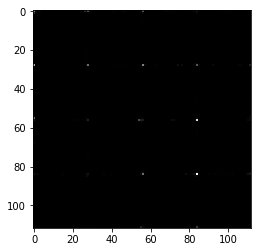

Epoch 1/2... Discriminator Loss: 1.3523... Generator Loss: 0.7570
Epoch 1/2... Discriminator Loss: 0.9187... Generator Loss: 1.3458
Epoch 1/2... Discriminator Loss: 1.2132... Generator Loss: 3.0817
Epoch 1/2... Discriminator Loss: 1.1124... Generator Loss: 1.1220
Epoch 1/2... Discriminator Loss: 0.7802... Generator Loss: 1.4068
Epoch 1/2... Discriminator Loss: 0.7955... Generator Loss: 1.6944
Epoch 1/2... Discriminator Loss: 0.9311... Generator Loss: 1.1935
Epoch 1/2... Discriminator Loss: 1.1708... Generator Loss: 0.8956
Epoch 1/2... Discriminator Loss: 1.0633... Generator Loss: 0.9459
Epoch 1/2... Discriminator Loss: 0.8744... Generator Loss: 1.9692


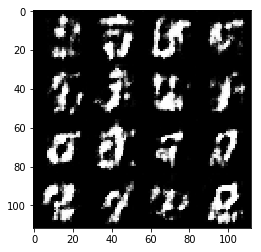

Epoch 1/2... Discriminator Loss: 0.8751... Generator Loss: 1.8381
Epoch 1/2... Discriminator Loss: 0.9691... Generator Loss: 1.5123
Epoch 1/2... Discriminator Loss: 1.0913... Generator Loss: 1.2896
Epoch 1/2... Discriminator Loss: 1.2910... Generator Loss: 0.7653
Epoch 1/2... Discriminator Loss: 1.0494... Generator Loss: 1.1259
Epoch 1/2... Discriminator Loss: 1.1253... Generator Loss: 2.1505
Epoch 1/2... Discriminator Loss: 1.2266... Generator Loss: 1.2465
Epoch 1/2... Discriminator Loss: 0.9903... Generator Loss: 1.2692
Epoch 1/2... Discriminator Loss: 0.8504... Generator Loss: 1.4567
Epoch 1/2... Discriminator Loss: 0.9310... Generator Loss: 1.2915


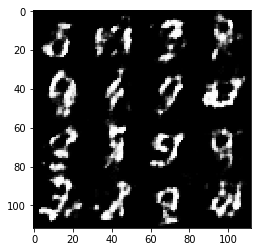

Epoch 1/2... Discriminator Loss: 1.1276... Generator Loss: 0.9985
Epoch 1/2... Discriminator Loss: 0.9451... Generator Loss: 1.3610
Epoch 1/2... Discriminator Loss: 1.0423... Generator Loss: 1.5254
Epoch 1/2... Discriminator Loss: 0.9275... Generator Loss: 1.1583
Epoch 1/2... Discriminator Loss: 1.0150... Generator Loss: 1.1032
Epoch 1/2... Discriminator Loss: 0.8776... Generator Loss: 1.5461
Epoch 1/2... Discriminator Loss: 0.8308... Generator Loss: 1.2173
Epoch 1/2... Discriminator Loss: 0.9574... Generator Loss: 1.3484
Epoch 1/2... Discriminator Loss: 0.9763... Generator Loss: 0.9844
Epoch 1/2... Discriminator Loss: 0.9045... Generator Loss: 1.5223


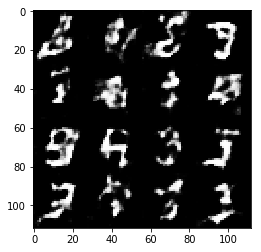

Epoch 1/2... Discriminator Loss: 0.8160... Generator Loss: 1.4031
Epoch 1/2... Discriminator Loss: 0.8401... Generator Loss: 1.5526
Epoch 1/2... Discriminator Loss: 0.9565... Generator Loss: 1.2796
Epoch 1/2... Discriminator Loss: 0.8738... Generator Loss: 1.1704
Epoch 1/2... Discriminator Loss: 1.0143... Generator Loss: 1.1208
Epoch 1/2... Discriminator Loss: 1.0135... Generator Loss: 1.3200
Epoch 1/2... Discriminator Loss: 1.0225... Generator Loss: 1.3746
Epoch 1/2... Discriminator Loss: 0.7156... Generator Loss: 1.8224
Epoch 1/2... Discriminator Loss: 0.9281... Generator Loss: 1.3477
Epoch 1/2... Discriminator Loss: 0.8883... Generator Loss: 1.0653


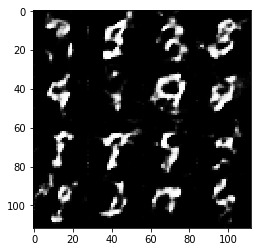

Epoch 1/2... Discriminator Loss: 0.9820... Generator Loss: 1.5334
Epoch 1/2... Discriminator Loss: 0.9258... Generator Loss: 1.3939
Epoch 1/2... Discriminator Loss: 0.9232... Generator Loss: 1.6254
Epoch 1/2... Discriminator Loss: 0.8915... Generator Loss: 1.4023
Epoch 1/2... Discriminator Loss: 0.6549... Generator Loss: 1.7639
Epoch 1/2... Discriminator Loss: 0.9174... Generator Loss: 1.7647
Epoch 1/2... Discriminator Loss: 0.9001... Generator Loss: 1.5174
Epoch 1/2... Discriminator Loss: 0.8683... Generator Loss: 1.2306
Epoch 1/2... Discriminator Loss: 0.9122... Generator Loss: 1.0301
Epoch 1/2... Discriminator Loss: 0.9201... Generator Loss: 1.8604


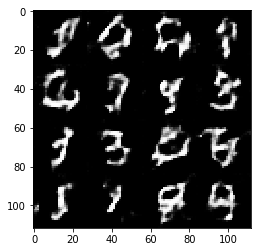

Epoch 1/2... Discriminator Loss: 0.9389... Generator Loss: 1.0201
Epoch 1/2... Discriminator Loss: 0.9246... Generator Loss: 1.1619
Epoch 1/2... Discriminator Loss: 0.8097... Generator Loss: 1.6704
Epoch 1/2... Discriminator Loss: 0.9048... Generator Loss: 1.4232
Epoch 1/2... Discriminator Loss: 0.8908... Generator Loss: 1.6226
Epoch 1/2... Discriminator Loss: 0.9400... Generator Loss: 1.6585
Epoch 1/2... Discriminator Loss: 0.9764... Generator Loss: 2.1229
Epoch 1/2... Discriminator Loss: 1.0504... Generator Loss: 1.4965
Epoch 1/2... Discriminator Loss: 0.9740... Generator Loss: 1.6967
Epoch 1/2... Discriminator Loss: 0.9440... Generator Loss: 1.3190


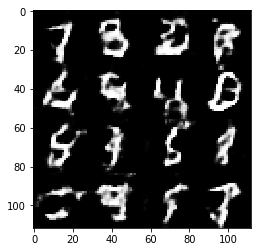

Epoch 1/2... Discriminator Loss: 0.8010... Generator Loss: 1.6946
Epoch 1/2... Discriminator Loss: 0.8495... Generator Loss: 1.3471
Epoch 1/2... Discriminator Loss: 0.7912... Generator Loss: 1.6410
Epoch 1/2... Discriminator Loss: 0.8658... Generator Loss: 1.1861
Epoch 1/2... Discriminator Loss: 0.7910... Generator Loss: 1.8354
Epoch 1/2... Discriminator Loss: 0.9511... Generator Loss: 1.3475
Epoch 1/2... Discriminator Loss: 0.7556... Generator Loss: 1.8981
Epoch 1/2... Discriminator Loss: 0.9136... Generator Loss: 1.8628
Epoch 1/2... Discriminator Loss: 1.0242... Generator Loss: 1.0728
Epoch 1/2... Discriminator Loss: 0.7996... Generator Loss: 1.4620


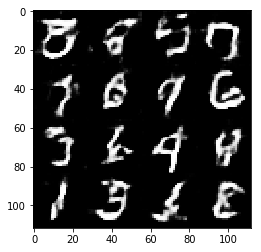

Epoch 1/2... Discriminator Loss: 0.8164... Generator Loss: 1.2022
Epoch 1/2... Discriminator Loss: 1.0926... Generator Loss: 1.4073
Epoch 1/2... Discriminator Loss: 0.8220... Generator Loss: 1.7913
Epoch 1/2... Discriminator Loss: 0.9929... Generator Loss: 1.4740
Epoch 1/2... Discriminator Loss: 0.9614... Generator Loss: 1.6596
Epoch 1/2... Discriminator Loss: 1.0773... Generator Loss: 2.2053
Epoch 1/2... Discriminator Loss: 0.7617... Generator Loss: 1.3197
Epoch 1/2... Discriminator Loss: 0.7996... Generator Loss: 1.7346
Epoch 1/2... Discriminator Loss: 0.9525... Generator Loss: 0.9797
Epoch 1/2... Discriminator Loss: 0.9331... Generator Loss: 1.7182


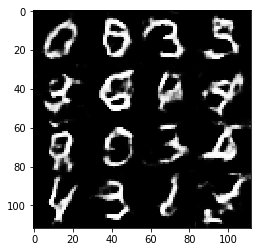

Epoch 1/2... Discriminator Loss: 0.9432... Generator Loss: 1.5144
Epoch 1/2... Discriminator Loss: 0.7943... Generator Loss: 1.5082
Epoch 1/2... Discriminator Loss: 1.1300... Generator Loss: 0.9447
Epoch 1/2... Discriminator Loss: 0.8705... Generator Loss: 1.3552
Epoch 1/2... Discriminator Loss: 0.9379... Generator Loss: 1.5807
Epoch 1/2... Discriminator Loss: 0.8889... Generator Loss: 1.6431
Epoch 1/2... Discriminator Loss: 0.9752... Generator Loss: 1.3498
Epoch 1/2... Discriminator Loss: 0.9570... Generator Loss: 1.0825
Epoch 1/2... Discriminator Loss: 0.8079... Generator Loss: 1.4703
Epoch 1/2... Discriminator Loss: 0.8339... Generator Loss: 1.1495


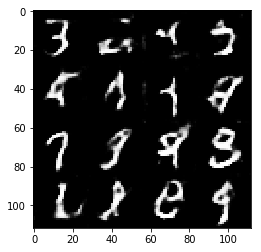

Epoch 1/2... Discriminator Loss: 1.0325... Generator Loss: 1.1503
Epoch 1/2... Discriminator Loss: 1.1508... Generator Loss: 1.0824
Epoch 1/2... Discriminator Loss: 0.8136... Generator Loss: 1.4800
Epoch 1/2... Discriminator Loss: 1.1272... Generator Loss: 0.9604
Epoch 1/2... Discriminator Loss: 0.9712... Generator Loss: 1.6910
Epoch 1/2... Discriminator Loss: 0.9168... Generator Loss: 1.3225
Epoch 1/2... Discriminator Loss: 1.0112... Generator Loss: 1.0349
Epoch 1/2... Discriminator Loss: 1.0247... Generator Loss: 1.2723
Epoch 1/2... Discriminator Loss: 0.8527... Generator Loss: 1.3303
Epoch 1/2... Discriminator Loss: 0.9515... Generator Loss: 1.2441


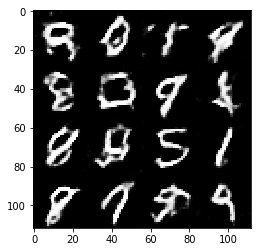

Epoch 1/2... Discriminator Loss: 1.0377... Generator Loss: 1.0037
Epoch 1/2... Discriminator Loss: 0.9489... Generator Loss: 1.2584
Epoch 1/2... Discriminator Loss: 0.9773... Generator Loss: 1.8368
Epoch 1/2... Discriminator Loss: 0.9000... Generator Loss: 1.2269
Epoch 1/2... Discriminator Loss: 0.9802... Generator Loss: 1.4941
Epoch 1/2... Discriminator Loss: 1.0236... Generator Loss: 1.5273
Epoch 1/2... Discriminator Loss: 0.9753... Generator Loss: 1.5606
Epoch 1/2... Discriminator Loss: 1.1317... Generator Loss: 1.3921
Epoch 1/2... Discriminator Loss: 0.9822... Generator Loss: 1.1444
Epoch 1/2... Discriminator Loss: 0.9972... Generator Loss: 1.4783


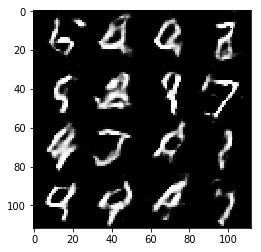

Epoch 1/2... Discriminator Loss: 0.8710... Generator Loss: 1.4481
Epoch 1/2... Discriminator Loss: 0.9821... Generator Loss: 1.2218
Epoch 1/2... Discriminator Loss: 0.7905... Generator Loss: 1.6396
Epoch 1/2... Discriminator Loss: 0.8746... Generator Loss: 1.5734
Epoch 1/2... Discriminator Loss: 0.8965... Generator Loss: 1.6820
Epoch 1/2... Discriminator Loss: 0.9150... Generator Loss: 0.9657
Epoch 1/2... Discriminator Loss: 0.9017... Generator Loss: 1.0588
Epoch 1/2... Discriminator Loss: 0.9400... Generator Loss: 1.7150
Epoch 1/2... Discriminator Loss: 0.9496... Generator Loss: 1.2220
Epoch 1/2... Discriminator Loss: 0.9782... Generator Loss: 1.2007


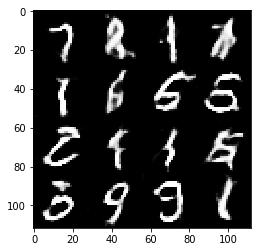

Epoch 1/2... Discriminator Loss: 1.1461... Generator Loss: 1.2340
Epoch 1/2... Discriminator Loss: 1.0616... Generator Loss: 1.6076
Epoch 1/2... Discriminator Loss: 0.8888... Generator Loss: 1.2313
Epoch 1/2... Discriminator Loss: 0.8423... Generator Loss: 1.6048
Epoch 1/2... Discriminator Loss: 0.8476... Generator Loss: 1.3709
Epoch 1/2... Discriminator Loss: 0.7634... Generator Loss: 1.5503
Epoch 1/2... Discriminator Loss: 1.0464... Generator Loss: 1.3803
Epoch 1/2... Discriminator Loss: 0.9823... Generator Loss: 1.3081
Epoch 1/2... Discriminator Loss: 1.0107... Generator Loss: 1.4683
Epoch 1/2... Discriminator Loss: 0.8866... Generator Loss: 1.4053


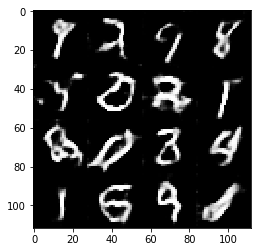

Epoch 1/2... Discriminator Loss: 0.9734... Generator Loss: 1.2121
Epoch 1/2... Discriminator Loss: 0.8269... Generator Loss: 1.1322
Epoch 1/2... Discriminator Loss: 0.9847... Generator Loss: 1.3124
Epoch 1/2... Discriminator Loss: 1.1759... Generator Loss: 1.1351
Epoch 1/2... Discriminator Loss: 1.1094... Generator Loss: 0.9410
Epoch 1/2... Discriminator Loss: 0.9870... Generator Loss: 0.7685
Epoch 1/2... Discriminator Loss: 0.8479... Generator Loss: 1.5029
Epoch 1/2... Discriminator Loss: 0.9536... Generator Loss: 1.1533
Epoch 1/2... Discriminator Loss: 0.8698... Generator Loss: 1.2308
Epoch 1/2... Discriminator Loss: 0.7281... Generator Loss: 1.5226


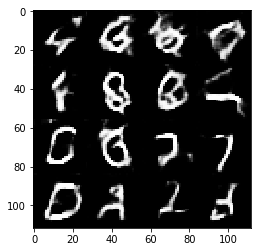

Epoch 1/2... Discriminator Loss: 0.8346... Generator Loss: 1.2647
Epoch 1/2... Discriminator Loss: 0.9045... Generator Loss: 1.1131
Epoch 1/2... Discriminator Loss: 1.0217... Generator Loss: 1.0179
Epoch 1/2... Discriminator Loss: 1.1381... Generator Loss: 1.1256
Epoch 1/2... Discriminator Loss: 0.8777... Generator Loss: 1.1906
Epoch 1/2... Discriminator Loss: 0.9173... Generator Loss: 1.3705
Epoch 1/2... Discriminator Loss: 1.0034... Generator Loss: 1.5161
Epoch 1/2... Discriminator Loss: 1.0825... Generator Loss: 1.3425
Epoch 1/2... Discriminator Loss: 0.8686... Generator Loss: 1.8399
Epoch 1/2... Discriminator Loss: 1.0944... Generator Loss: 0.9051


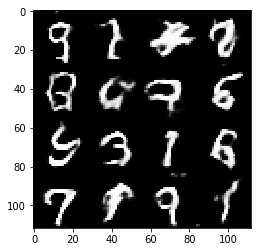

Epoch 1/2... Discriminator Loss: 0.9237... Generator Loss: 1.1657
Epoch 1/2... Discriminator Loss: 0.7892... Generator Loss: 1.3506
Epoch 1/2... Discriminator Loss: 1.0264... Generator Loss: 1.3436
Epoch 1/2... Discriminator Loss: 1.1202... Generator Loss: 1.2449
Epoch 1/2... Discriminator Loss: 0.8676... Generator Loss: 1.3783
Epoch 1/2... Discriminator Loss: 1.0690... Generator Loss: 1.3502
Epoch 1/2... Discriminator Loss: 0.9317... Generator Loss: 1.5643
Epoch 1/2... Discriminator Loss: 0.7514... Generator Loss: 1.5087
Epoch 1/2... Discriminator Loss: 1.2173... Generator Loss: 0.9658
Epoch 1/2... Discriminator Loss: 0.7801... Generator Loss: 1.2790


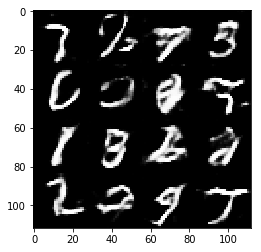

Epoch 1/2... Discriminator Loss: 0.9766... Generator Loss: 1.1034
Epoch 1/2... Discriminator Loss: 1.0451... Generator Loss: 1.8610
Epoch 1/2... Discriminator Loss: 1.0362... Generator Loss: 1.4418
Epoch 1/2... Discriminator Loss: 0.8585... Generator Loss: 1.4636
Epoch 1/2... Discriminator Loss: 0.9225... Generator Loss: 1.5731
Epoch 1/2... Discriminator Loss: 0.8255... Generator Loss: 1.6118
Epoch 1/2... Discriminator Loss: 0.9490... Generator Loss: 1.1147
Epoch 1/2... Discriminator Loss: 0.8077... Generator Loss: 1.2999
Epoch 1/2... Discriminator Loss: 0.7973... Generator Loss: 1.3326
Epoch 1/2... Discriminator Loss: 0.9561... Generator Loss: 1.2706


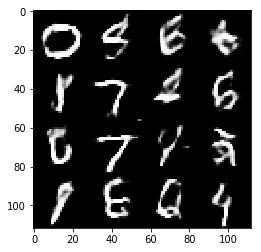

Epoch 1/2... Discriminator Loss: 0.9356... Generator Loss: 1.2350
Epoch 1/2... Discriminator Loss: 0.8665... Generator Loss: 1.4073
Epoch 1/2... Discriminator Loss: 1.0748... Generator Loss: 0.8811
Epoch 1/2... Discriminator Loss: 1.0921... Generator Loss: 1.1743
Epoch 1/2... Discriminator Loss: 1.0040... Generator Loss: 1.7783
Epoch 1/2... Discriminator Loss: 0.9351... Generator Loss: 1.4233
Epoch 1/2... Discriminator Loss: 0.8748... Generator Loss: 1.2779
Epoch 1/2... Discriminator Loss: 0.6879... Generator Loss: 1.5211
Epoch 2/2... Discriminator Loss: 0.8670... Generator Loss: 1.6789
Epoch 2/2... Discriminator Loss: 1.1581... Generator Loss: 0.7549


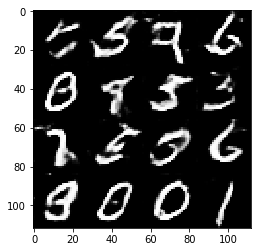

Epoch 2/2... Discriminator Loss: 0.8135... Generator Loss: 1.4300
Epoch 2/2... Discriminator Loss: 0.9500... Generator Loss: 1.6810
Epoch 2/2... Discriminator Loss: 0.8027... Generator Loss: 1.5643
Epoch 2/2... Discriminator Loss: 0.9137... Generator Loss: 1.1188
Epoch 2/2... Discriminator Loss: 0.8953... Generator Loss: 1.1444
Epoch 2/2... Discriminator Loss: 0.9962... Generator Loss: 1.3605
Epoch 2/2... Discriminator Loss: 0.9814... Generator Loss: 1.6620
Epoch 2/2... Discriminator Loss: 1.0205... Generator Loss: 1.6762
Epoch 2/2... Discriminator Loss: 0.9146... Generator Loss: 1.5197
Epoch 2/2... Discriminator Loss: 0.9289... Generator Loss: 1.7424


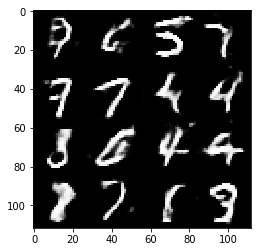

Epoch 2/2... Discriminator Loss: 0.9714... Generator Loss: 2.1043
Epoch 2/2... Discriminator Loss: 0.8630... Generator Loss: 1.4177
Epoch 2/2... Discriminator Loss: 0.8443... Generator Loss: 1.4352
Epoch 2/2... Discriminator Loss: 0.9171... Generator Loss: 1.1161
Epoch 2/2... Discriminator Loss: 0.8766... Generator Loss: 1.5347
Epoch 2/2... Discriminator Loss: 0.8986... Generator Loss: 1.6021
Epoch 2/2... Discriminator Loss: 0.8187... Generator Loss: 1.7702
Epoch 2/2... Discriminator Loss: 0.8661... Generator Loss: 1.4607
Epoch 2/2... Discriminator Loss: 0.8176... Generator Loss: 1.4938
Epoch 2/2... Discriminator Loss: 0.6324... Generator Loss: 1.6408


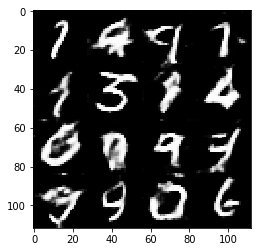

Epoch 2/2... Discriminator Loss: 0.9035... Generator Loss: 1.2988
Epoch 2/2... Discriminator Loss: 0.8798... Generator Loss: 1.5984
Epoch 2/2... Discriminator Loss: 0.9597... Generator Loss: 1.5082
Epoch 2/2... Discriminator Loss: 0.9933... Generator Loss: 1.0584
Epoch 2/2... Discriminator Loss: 0.8730... Generator Loss: 1.2337
Epoch 2/2... Discriminator Loss: 0.9079... Generator Loss: 1.6104
Epoch 2/2... Discriminator Loss: 0.9352... Generator Loss: 1.4650
Epoch 2/2... Discriminator Loss: 0.9592... Generator Loss: 1.3450
Epoch 2/2... Discriminator Loss: 1.0233... Generator Loss: 1.5294
Epoch 2/2... Discriminator Loss: 0.8481... Generator Loss: 1.3655


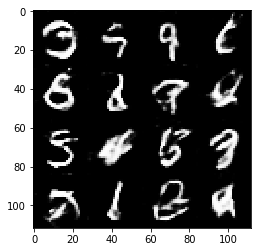

Epoch 2/2... Discriminator Loss: 0.7582... Generator Loss: 1.4935
Epoch 2/2... Discriminator Loss: 1.0910... Generator Loss: 1.0080
Epoch 2/2... Discriminator Loss: 0.8033... Generator Loss: 1.5718
Epoch 2/2... Discriminator Loss: 0.8574... Generator Loss: 1.5768
Epoch 2/2... Discriminator Loss: 1.0415... Generator Loss: 1.6647
Epoch 2/2... Discriminator Loss: 0.7076... Generator Loss: 1.5011
Epoch 2/2... Discriminator Loss: 0.9737... Generator Loss: 1.3369
Epoch 2/2... Discriminator Loss: 0.8225... Generator Loss: 1.9361
Epoch 2/2... Discriminator Loss: 0.9517... Generator Loss: 1.0211
Epoch 2/2... Discriminator Loss: 1.0154... Generator Loss: 1.6964


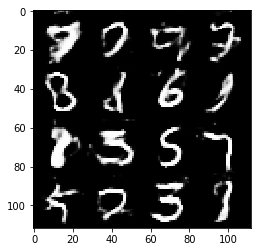

Epoch 2/2... Discriminator Loss: 0.8624... Generator Loss: 1.3065
Epoch 2/2... Discriminator Loss: 0.7270... Generator Loss: 1.5301
Epoch 2/2... Discriminator Loss: 1.0265... Generator Loss: 1.2082
Epoch 2/2... Discriminator Loss: 1.0521... Generator Loss: 1.4348
Epoch 2/2... Discriminator Loss: 0.8520... Generator Loss: 1.5539
Epoch 2/2... Discriminator Loss: 0.8862... Generator Loss: 1.5299
Epoch 2/2... Discriminator Loss: 0.8230... Generator Loss: 1.5437
Epoch 2/2... Discriminator Loss: 1.1284... Generator Loss: 1.2292
Epoch 2/2... Discriminator Loss: 0.9949... Generator Loss: 1.2037
Epoch 2/2... Discriminator Loss: 0.9470... Generator Loss: 2.2032


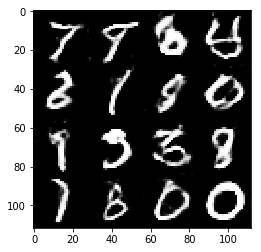

Epoch 2/2... Discriminator Loss: 0.8608... Generator Loss: 1.2272
Epoch 2/2... Discriminator Loss: 0.9582... Generator Loss: 1.2445
Epoch 2/2... Discriminator Loss: 1.0951... Generator Loss: 1.5807
Epoch 2/2... Discriminator Loss: 0.8577... Generator Loss: 1.5928
Epoch 2/2... Discriminator Loss: 0.7793... Generator Loss: 1.2981
Epoch 2/2... Discriminator Loss: 0.7880... Generator Loss: 1.4100
Epoch 2/2... Discriminator Loss: 0.9352... Generator Loss: 1.5414
Epoch 2/2... Discriminator Loss: 0.7535... Generator Loss: 1.4691
Epoch 2/2... Discriminator Loss: 0.9883... Generator Loss: 1.5403
Epoch 2/2... Discriminator Loss: 0.9721... Generator Loss: 1.1178


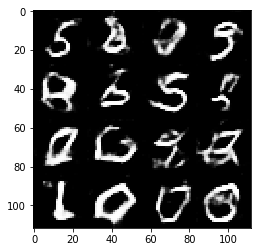

Epoch 2/2... Discriminator Loss: 0.9704... Generator Loss: 2.0526
Epoch 2/2... Discriminator Loss: 0.9142... Generator Loss: 1.2375
Epoch 2/2... Discriminator Loss: 0.9746... Generator Loss: 1.6546
Epoch 2/2... Discriminator Loss: 0.7914... Generator Loss: 1.3733
Epoch 2/2... Discriminator Loss: 0.8830... Generator Loss: 1.5296
Epoch 2/2... Discriminator Loss: 1.0864... Generator Loss: 1.3146
Epoch 2/2... Discriminator Loss: 0.9043... Generator Loss: 1.1218
Epoch 2/2... Discriminator Loss: 0.9928... Generator Loss: 1.2004
Epoch 2/2... Discriminator Loss: 0.9388... Generator Loss: 1.8044
Epoch 2/2... Discriminator Loss: 0.8813... Generator Loss: 1.4993


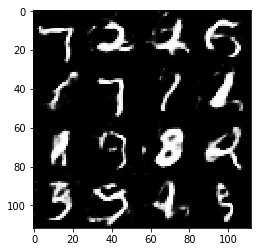

Epoch 2/2... Discriminator Loss: 0.8162... Generator Loss: 1.4903
Epoch 2/2... Discriminator Loss: 0.9066... Generator Loss: 1.1805
Epoch 2/2... Discriminator Loss: 0.8296... Generator Loss: 1.5889
Epoch 2/2... Discriminator Loss: 1.0774... Generator Loss: 1.3745
Epoch 2/2... Discriminator Loss: 1.0343... Generator Loss: 1.4278
Epoch 2/2... Discriminator Loss: 0.8526... Generator Loss: 1.2850
Epoch 2/2... Discriminator Loss: 0.8820... Generator Loss: 1.7254
Epoch 2/2... Discriminator Loss: 0.9422... Generator Loss: 1.2757
Epoch 2/2... Discriminator Loss: 0.9502... Generator Loss: 1.1206
Epoch 2/2... Discriminator Loss: 0.9107... Generator Loss: 1.4277


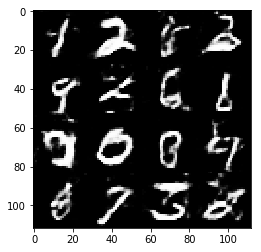

Epoch 2/2... Discriminator Loss: 0.7748... Generator Loss: 1.7768
Epoch 2/2... Discriminator Loss: 0.9366... Generator Loss: 1.1204
Epoch 2/2... Discriminator Loss: 0.8609... Generator Loss: 1.5193
Epoch 2/2... Discriminator Loss: 0.8640... Generator Loss: 1.1459
Epoch 2/2... Discriminator Loss: 0.8627... Generator Loss: 1.3136
Epoch 2/2... Discriminator Loss: 1.1473... Generator Loss: 1.1808
Epoch 2/2... Discriminator Loss: 0.7901... Generator Loss: 1.8265
Epoch 2/2... Discriminator Loss: 0.7826... Generator Loss: 2.3121
Epoch 2/2... Discriminator Loss: 0.8303... Generator Loss: 1.4139
Epoch 2/2... Discriminator Loss: 1.0611... Generator Loss: 1.6690


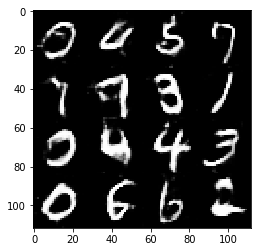

Epoch 2/2... Discriminator Loss: 0.9502... Generator Loss: 1.5393
Epoch 2/2... Discriminator Loss: 0.9466... Generator Loss: 1.1657
Epoch 2/2... Discriminator Loss: 0.9065... Generator Loss: 1.5182
Epoch 2/2... Discriminator Loss: 0.9296... Generator Loss: 1.1245
Epoch 2/2... Discriminator Loss: 1.1461... Generator Loss: 1.2664
Epoch 2/2... Discriminator Loss: 0.9631... Generator Loss: 1.2255
Epoch 2/2... Discriminator Loss: 1.0340... Generator Loss: 1.3355
Epoch 2/2... Discriminator Loss: 0.8783... Generator Loss: 1.2934
Epoch 2/2... Discriminator Loss: 0.8746... Generator Loss: 1.5352
Epoch 2/2... Discriminator Loss: 0.8558... Generator Loss: 1.6887


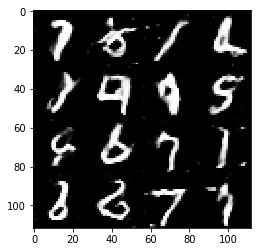

Epoch 2/2... Discriminator Loss: 0.9855... Generator Loss: 1.6543
Epoch 2/2... Discriminator Loss: 0.8478... Generator Loss: 1.5083
Epoch 2/2... Discriminator Loss: 0.9511... Generator Loss: 1.6462
Epoch 2/2... Discriminator Loss: 1.0047... Generator Loss: 1.1721
Epoch 2/2... Discriminator Loss: 0.8628... Generator Loss: 1.4578
Epoch 2/2... Discriminator Loss: 1.0144... Generator Loss: 1.7246
Epoch 2/2... Discriminator Loss: 0.8514... Generator Loss: 1.6161
Epoch 2/2... Discriminator Loss: 0.8506... Generator Loss: 1.5616
Epoch 2/2... Discriminator Loss: 0.8751... Generator Loss: 1.7107
Epoch 2/2... Discriminator Loss: 0.8958... Generator Loss: 1.4337


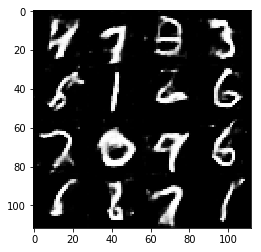

Epoch 2/2... Discriminator Loss: 1.1275... Generator Loss: 0.8148
Epoch 2/2... Discriminator Loss: 0.9041... Generator Loss: 1.3052
Epoch 2/2... Discriminator Loss: 1.0343... Generator Loss: 1.0318
Epoch 2/2... Discriminator Loss: 0.9835... Generator Loss: 1.6097
Epoch 2/2... Discriminator Loss: 0.8763... Generator Loss: 1.7178
Epoch 2/2... Discriminator Loss: 0.8146... Generator Loss: 1.1875
Epoch 2/2... Discriminator Loss: 0.7943... Generator Loss: 1.6320
Epoch 2/2... Discriminator Loss: 0.9892... Generator Loss: 1.1967
Epoch 2/2... Discriminator Loss: 0.8671... Generator Loss: 1.7983
Epoch 2/2... Discriminator Loss: 0.9338... Generator Loss: 1.4939


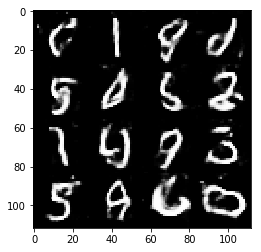

Epoch 2/2... Discriminator Loss: 1.0385... Generator Loss: 1.2261
Epoch 2/2... Discriminator Loss: 0.9066... Generator Loss: 1.3571
Epoch 2/2... Discriminator Loss: 0.7641... Generator Loss: 1.4600
Epoch 2/2... Discriminator Loss: 0.8087... Generator Loss: 1.1921
Epoch 2/2... Discriminator Loss: 0.8718... Generator Loss: 1.5892
Epoch 2/2... Discriminator Loss: 1.1888... Generator Loss: 0.9463
Epoch 2/2... Discriminator Loss: 0.7429... Generator Loss: 1.4156
Epoch 2/2... Discriminator Loss: 0.7570... Generator Loss: 1.4710
Epoch 2/2... Discriminator Loss: 1.0127... Generator Loss: 1.8692
Epoch 2/2... Discriminator Loss: 0.9575... Generator Loss: 1.4615


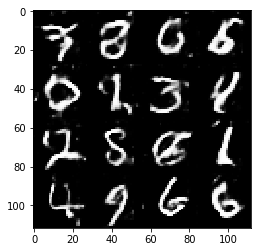

Epoch 2/2... Discriminator Loss: 0.8351... Generator Loss: 1.4135
Epoch 2/2... Discriminator Loss: 1.0422... Generator Loss: 1.3696
Epoch 2/2... Discriminator Loss: 0.6749... Generator Loss: 1.3855
Epoch 2/2... Discriminator Loss: 0.9659... Generator Loss: 1.3099
Epoch 2/2... Discriminator Loss: 1.0639... Generator Loss: 1.7787
Epoch 2/2... Discriminator Loss: 0.9808... Generator Loss: 1.2596
Epoch 2/2... Discriminator Loss: 0.8544... Generator Loss: 1.9074
Epoch 2/2... Discriminator Loss: 0.7230... Generator Loss: 1.4858
Epoch 2/2... Discriminator Loss: 0.9501... Generator Loss: 1.2707
Epoch 2/2... Discriminator Loss: 1.1359... Generator Loss: 1.5035


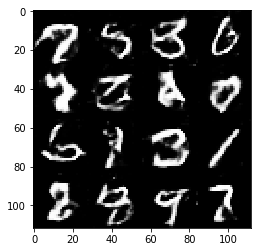

Epoch 2/2... Discriminator Loss: 0.8334... Generator Loss: 1.2807
Epoch 2/2... Discriminator Loss: 1.0232... Generator Loss: 1.8965
Epoch 2/2... Discriminator Loss: 0.8662... Generator Loss: 1.1164
Epoch 2/2... Discriminator Loss: 0.9483... Generator Loss: 1.9589
Epoch 2/2... Discriminator Loss: 0.9108... Generator Loss: 1.3624
Epoch 2/2... Discriminator Loss: 0.8859... Generator Loss: 2.1055
Epoch 2/2... Discriminator Loss: 0.8439... Generator Loss: 1.3165
Epoch 2/2... Discriminator Loss: 0.8793... Generator Loss: 1.3078
Epoch 2/2... Discriminator Loss: 0.8937... Generator Loss: 1.5968
Epoch 2/2... Discriminator Loss: 0.7103... Generator Loss: 1.5273


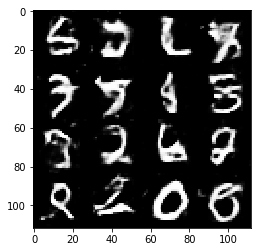

Epoch 2/2... Discriminator Loss: 0.9610... Generator Loss: 1.2394
Epoch 2/2... Discriminator Loss: 0.8175... Generator Loss: 1.3062
Epoch 2/2... Discriminator Loss: 0.9512... Generator Loss: 1.2236
Epoch 2/2... Discriminator Loss: 1.0134... Generator Loss: 1.1896
Epoch 2/2... Discriminator Loss: 0.9572... Generator Loss: 1.6960
Epoch 2/2... Discriminator Loss: 0.9883... Generator Loss: 1.2445
Epoch 2/2... Discriminator Loss: 0.7940... Generator Loss: 1.6651
Epoch 2/2... Discriminator Loss: 1.0020... Generator Loss: 1.9802
Epoch 2/2... Discriminator Loss: 1.0222... Generator Loss: 0.9991
Epoch 2/2... Discriminator Loss: 0.6955... Generator Loss: 1.4079


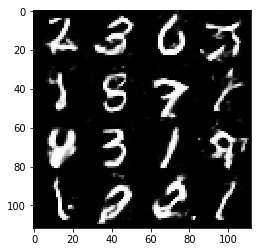

Epoch 2/2... Discriminator Loss: 0.6718... Generator Loss: 2.0597
Epoch 2/2... Discriminator Loss: 0.8107... Generator Loss: 1.3043
Epoch 2/2... Discriminator Loss: 0.7945... Generator Loss: 1.2941
Epoch 2/2... Discriminator Loss: 0.8748... Generator Loss: 1.5011
Epoch 2/2... Discriminator Loss: 0.9010... Generator Loss: 1.1171
Epoch 2/2... Discriminator Loss: 1.1320... Generator Loss: 1.0235
Epoch 2/2... Discriminator Loss: 0.9379... Generator Loss: 1.4820
Epoch 2/2... Discriminator Loss: 0.9216... Generator Loss: 1.3549
Epoch 2/2... Discriminator Loss: 0.8681... Generator Loss: 1.1344
Epoch 2/2... Discriminator Loss: 0.9376... Generator Loss: 1.1148


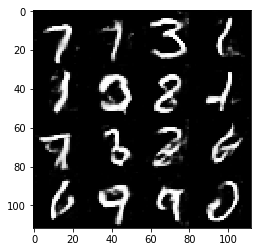

Epoch 2/2... Discriminator Loss: 0.8571... Generator Loss: 1.5788
Epoch 2/2... Discriminator Loss: 0.9745... Generator Loss: 1.7425
Epoch 2/2... Discriminator Loss: 0.8379... Generator Loss: 1.5449
Epoch 2/2... Discriminator Loss: 0.7968... Generator Loss: 1.7567
Epoch 2/2... Discriminator Loss: 0.8615... Generator Loss: 1.5460
Epoch 2/2... Discriminator Loss: 0.9751... Generator Loss: 1.5798
Epoch 2/2... Discriminator Loss: 0.8444... Generator Loss: 1.6290
Epoch 2/2... Discriminator Loss: 0.8620... Generator Loss: 1.3629
Epoch 2/2... Discriminator Loss: 0.8681... Generator Loss: 1.2726
Epoch 2/2... Discriminator Loss: 0.8374... Generator Loss: 1.6215


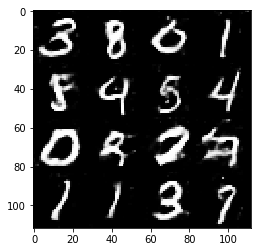

Epoch 2/2... Discriminator Loss: 1.0139... Generator Loss: 1.2831
Epoch 2/2... Discriminator Loss: 0.8234... Generator Loss: 1.6303
Epoch 2/2... Discriminator Loss: 0.8907... Generator Loss: 1.2620
Epoch 2/2... Discriminator Loss: 0.8007... Generator Loss: 1.3330
Epoch 2/2... Discriminator Loss: 1.0418... Generator Loss: 0.9014
Epoch 2/2... Discriminator Loss: 0.7545... Generator Loss: 1.7102


In [19]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4757... Generator Loss: 3.1150
Epoch 1/1... Discriminator Loss: 0.4450... Generator Loss: 3.4177
Epoch 1/1... Discriminator Loss: 0.4211... Generator Loss: 3.0347
Epoch 1/1... Discriminator Loss: 0.4304... Generator Loss: 2.9027
Epoch 1/1... Discriminator Loss: 0.4297... Generator Loss: 3.4905
Epoch 1/1... Discriminator Loss: 0.4613... Generator Loss: 2.7337
Epoch 1/1... Discriminator Loss: 0.5555... Generator Loss: 1.9055
Epoch 1/1... Discriminator Loss: 0.4645... Generator Loss: 2.2987
Epoch 1/1... Discriminator Loss: 0.4785... Generator Loss: 3.1443


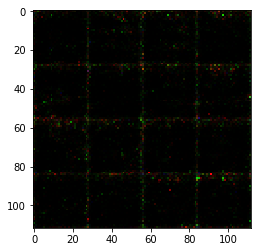

Epoch 1/1... Discriminator Loss: 0.4314... Generator Loss: 3.3286
Epoch 1/1... Discriminator Loss: 0.5214... Generator Loss: 2.3162
Epoch 1/1... Discriminator Loss: 0.5114... Generator Loss: 5.1635
Epoch 1/1... Discriminator Loss: 0.5629... Generator Loss: 2.2394
Epoch 1/1... Discriminator Loss: 0.3818... Generator Loss: 4.3450
Epoch 1/1... Discriminator Loss: 0.4206... Generator Loss: 4.5631
Epoch 1/1... Discriminator Loss: 0.4375... Generator Loss: 4.1044
Epoch 1/1... Discriminator Loss: 0.3791... Generator Loss: 3.6660
Epoch 1/1... Discriminator Loss: 0.4503... Generator Loss: 2.5757
Epoch 1/1... Discriminator Loss: 0.5034... Generator Loss: 2.4959


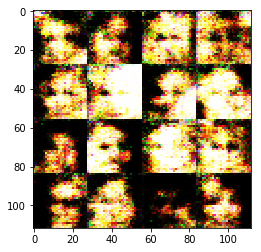

Epoch 1/1... Discriminator Loss: 0.4095... Generator Loss: 3.2866
Epoch 1/1... Discriminator Loss: 0.4575... Generator Loss: 2.5375
Epoch 1/1... Discriminator Loss: 0.4246... Generator Loss: 3.4963
Epoch 1/1... Discriminator Loss: 0.4139... Generator Loss: 3.3223
Epoch 1/1... Discriminator Loss: 0.3860... Generator Loss: 3.2316
Epoch 1/1... Discriminator Loss: 0.4180... Generator Loss: 3.8650
Epoch 1/1... Discriminator Loss: 0.4569... Generator Loss: 4.1553
Epoch 1/1... Discriminator Loss: 0.4675... Generator Loss: 2.6638
Epoch 1/1... Discriminator Loss: 0.6642... Generator Loss: 3.6113
Epoch 1/1... Discriminator Loss: 0.5067... Generator Loss: 3.0563


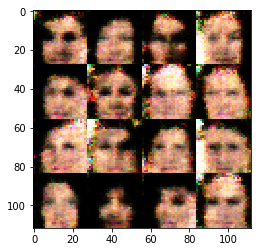

Epoch 1/1... Discriminator Loss: 0.7396... Generator Loss: 1.3558
Epoch 1/1... Discriminator Loss: 0.4560... Generator Loss: 2.5532
Epoch 1/1... Discriminator Loss: 0.4149... Generator Loss: 3.0188
Epoch 1/1... Discriminator Loss: 0.6323... Generator Loss: 1.6665
Epoch 1/1... Discriminator Loss: 0.4876... Generator Loss: 2.5096
Epoch 1/1... Discriminator Loss: 0.4655... Generator Loss: 2.5444
Epoch 1/1... Discriminator Loss: 0.5149... Generator Loss: 3.4821
Epoch 1/1... Discriminator Loss: 0.4344... Generator Loss: 3.1386
Epoch 1/1... Discriminator Loss: 0.6761... Generator Loss: 1.5131
Epoch 1/1... Discriminator Loss: 0.4399... Generator Loss: 2.7958


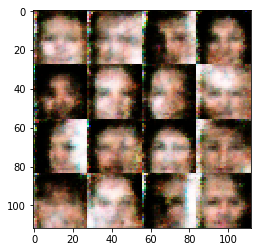

Epoch 1/1... Discriminator Loss: 0.5405... Generator Loss: 2.7869
Epoch 1/1... Discriminator Loss: 0.6515... Generator Loss: 1.8704
Epoch 1/1... Discriminator Loss: 0.6479... Generator Loss: 2.4473
Epoch 1/1... Discriminator Loss: 0.6249... Generator Loss: 1.6661
Epoch 1/1... Discriminator Loss: 0.6721... Generator Loss: 1.6038
Epoch 1/1... Discriminator Loss: 0.8202... Generator Loss: 1.8137
Epoch 1/1... Discriminator Loss: 0.6582... Generator Loss: 1.7967
Epoch 1/1... Discriminator Loss: 0.7791... Generator Loss: 1.9252
Epoch 1/1... Discriminator Loss: 0.9097... Generator Loss: 2.2858
Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 1.1480


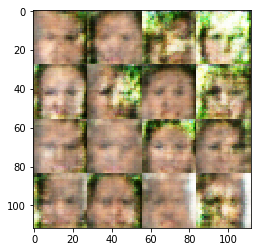

Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 1.1755
Epoch 1/1... Discriminator Loss: 0.6439... Generator Loss: 2.2114
Epoch 1/1... Discriminator Loss: 0.7174... Generator Loss: 1.7203
Epoch 1/1... Discriminator Loss: 0.8441... Generator Loss: 1.7460
Epoch 1/1... Discriminator Loss: 0.6733... Generator Loss: 2.4574
Epoch 1/1... Discriminator Loss: 0.8507... Generator Loss: 1.0352
Epoch 1/1... Discriminator Loss: 0.8921... Generator Loss: 1.2196
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.9536
Epoch 1/1... Discriminator Loss: 0.8429... Generator Loss: 1.4244
Epoch 1/1... Discriminator Loss: 0.7376... Generator Loss: 1.9199


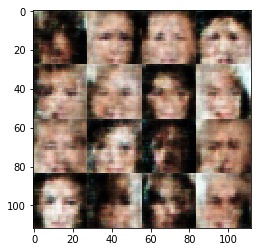

Epoch 1/1... Discriminator Loss: 0.6628... Generator Loss: 2.6425
Epoch 1/1... Discriminator Loss: 0.6894... Generator Loss: 1.7697
Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 1.4317
Epoch 1/1... Discriminator Loss: 0.8445... Generator Loss: 1.3941
Epoch 1/1... Discriminator Loss: 0.8500... Generator Loss: 1.3475
Epoch 1/1... Discriminator Loss: 0.7287... Generator Loss: 2.3953
Epoch 1/1... Discriminator Loss: 0.6315... Generator Loss: 2.4957
Epoch 1/1... Discriminator Loss: 0.7278... Generator Loss: 1.4893
Epoch 1/1... Discriminator Loss: 0.5645... Generator Loss: 1.7701
Epoch 1/1... Discriminator Loss: 0.8323... Generator Loss: 1.5598


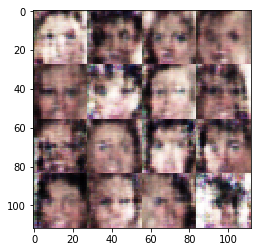

Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 1.0607
Epoch 1/1... Discriminator Loss: 0.9326... Generator Loss: 1.2842
Epoch 1/1... Discriminator Loss: 0.6550... Generator Loss: 1.9590
Epoch 1/1... Discriminator Loss: 0.8377... Generator Loss: 1.6090
Epoch 1/1... Discriminator Loss: 0.8922... Generator Loss: 1.2813
Epoch 1/1... Discriminator Loss: 0.8634... Generator Loss: 1.5456
Epoch 1/1... Discriminator Loss: 0.7347... Generator Loss: 1.8842
Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 1.4048
Epoch 1/1... Discriminator Loss: 0.8559... Generator Loss: 1.9798
Epoch 1/1... Discriminator Loss: 0.8490... Generator Loss: 1.1278


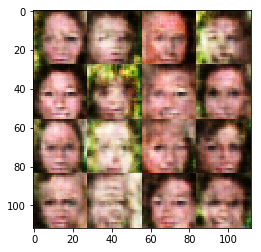

Epoch 1/1... Discriminator Loss: 0.9036... Generator Loss: 1.6093
Epoch 1/1... Discriminator Loss: 0.8042... Generator Loss: 1.3851
Epoch 1/1... Discriminator Loss: 0.9156... Generator Loss: 1.4031
Epoch 1/1... Discriminator Loss: 0.9863... Generator Loss: 1.3080
Epoch 1/1... Discriminator Loss: 0.9433... Generator Loss: 1.7706
Epoch 1/1... Discriminator Loss: 0.9425... Generator Loss: 1.9985
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 1.0062
Epoch 1/1... Discriminator Loss: 0.7595... Generator Loss: 1.6715
Epoch 1/1... Discriminator Loss: 0.9194... Generator Loss: 1.4527
Epoch 1/1... Discriminator Loss: 0.8957... Generator Loss: 1.3771


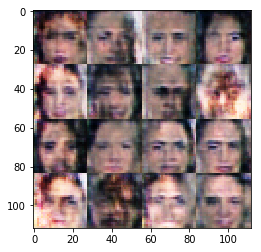

Epoch 1/1... Discriminator Loss: 1.0635... Generator Loss: 1.3741
Epoch 1/1... Discriminator Loss: 0.9870... Generator Loss: 1.0446
Epoch 1/1... Discriminator Loss: 0.8254... Generator Loss: 1.5128
Epoch 1/1... Discriminator Loss: 0.9772... Generator Loss: 1.2819
Epoch 1/1... Discriminator Loss: 0.8727... Generator Loss: 1.7208
Epoch 1/1... Discriminator Loss: 1.0541... Generator Loss: 2.0098
Epoch 1/1... Discriminator Loss: 0.9778... Generator Loss: 1.1765
Epoch 1/1... Discriminator Loss: 0.9483... Generator Loss: 1.6080
Epoch 1/1... Discriminator Loss: 0.7538... Generator Loss: 1.2981
Epoch 1/1... Discriminator Loss: 1.0013... Generator Loss: 1.0795


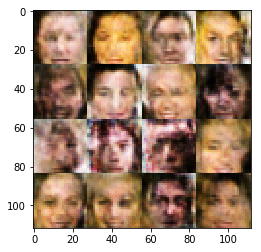

Epoch 1/1... Discriminator Loss: 0.7466... Generator Loss: 1.4609
Epoch 1/1... Discriminator Loss: 0.8883... Generator Loss: 1.4507
Epoch 1/1... Discriminator Loss: 0.8340... Generator Loss: 1.4534
Epoch 1/1... Discriminator Loss: 0.9001... Generator Loss: 1.6215
Epoch 1/1... Discriminator Loss: 0.8551... Generator Loss: 1.3042
Epoch 1/1... Discriminator Loss: 0.8242... Generator Loss: 1.6056
Epoch 1/1... Discriminator Loss: 0.8440... Generator Loss: 1.6966
Epoch 1/1... Discriminator Loss: 1.0878... Generator Loss: 1.1990
Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 1.6434
Epoch 1/1... Discriminator Loss: 0.9074... Generator Loss: 1.0806


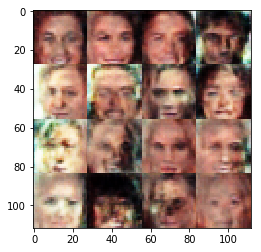

Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 1.5224
Epoch 1/1... Discriminator Loss: 1.0093... Generator Loss: 1.2203
Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 1.2823
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 1.0233
Epoch 1/1... Discriminator Loss: 1.0342... Generator Loss: 1.0047
Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 1.0384
Epoch 1/1... Discriminator Loss: 1.0012... Generator Loss: 1.5388
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 1.2657
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.9654
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 0.8383


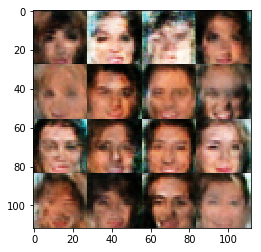

Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 1.3553
Epoch 1/1... Discriminator Loss: 0.9736... Generator Loss: 1.0749
Epoch 1/1... Discriminator Loss: 1.0137... Generator Loss: 1.5987
Epoch 1/1... Discriminator Loss: 1.1934... Generator Loss: 1.0653
Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 1.1529
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 1.1683
Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 1.2743
Epoch 1/1... Discriminator Loss: 0.9303... Generator Loss: 1.6176
Epoch 1/1... Discriminator Loss: 1.0439... Generator Loss: 1.1347
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 1.3791


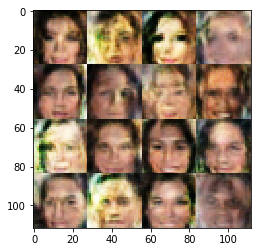

Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 1.3826
Epoch 1/1... Discriminator Loss: 0.9653... Generator Loss: 1.2014
Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 1.2361
Epoch 1/1... Discriminator Loss: 0.9079... Generator Loss: 1.0280
Epoch 1/1... Discriminator Loss: 1.0528... Generator Loss: 1.1011
Epoch 1/1... Discriminator Loss: 0.8927... Generator Loss: 1.1648
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.9084
Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 1.0423
Epoch 1/1... Discriminator Loss: 0.9955... Generator Loss: 1.1168
Epoch 1/1... Discriminator Loss: 1.0649... Generator Loss: 1.0348


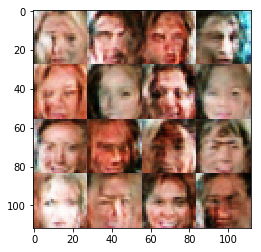

Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 1.1579
Epoch 1/1... Discriminator Loss: 1.1418... Generator Loss: 1.0244
Epoch 1/1... Discriminator Loss: 1.1549... Generator Loss: 0.9985
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 1.0518
Epoch 1/1... Discriminator Loss: 0.9332... Generator Loss: 1.3682
Epoch 1/1... Discriminator Loss: 1.0797... Generator Loss: 1.0360
Epoch 1/1... Discriminator Loss: 1.0668... Generator Loss: 1.3286
Epoch 1/1... Discriminator Loss: 0.9675... Generator Loss: 1.0696
Epoch 1/1... Discriminator Loss: 0.8512... Generator Loss: 1.1380
Epoch 1/1... Discriminator Loss: 0.8953... Generator Loss: 1.0143


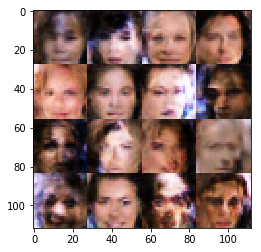

Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 1.2391
Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 1.0109
Epoch 1/1... Discriminator Loss: 1.0656... Generator Loss: 1.0161
Epoch 1/1... Discriminator Loss: 1.2077... Generator Loss: 0.8720
Epoch 1/1... Discriminator Loss: 1.0683... Generator Loss: 1.5413
Epoch 1/1... Discriminator Loss: 0.9636... Generator Loss: 1.3124
Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 1.0428
Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 1.0008
Epoch 1/1... Discriminator Loss: 1.0482... Generator Loss: 0.8673
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 1.3473


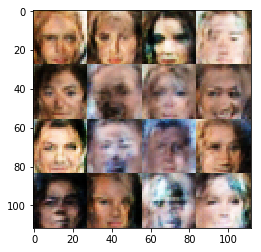

Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 0.9088
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 0.9733... Generator Loss: 1.2384
Epoch 1/1... Discriminator Loss: 0.8635... Generator Loss: 1.4336
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 1.1470
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 1.0340
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 1.2459
Epoch 1/1... Discriminator Loss: 1.0729... Generator Loss: 1.0705
Epoch 1/1... Discriminator Loss: 1.1295... Generator Loss: 1.3226
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 0.9192


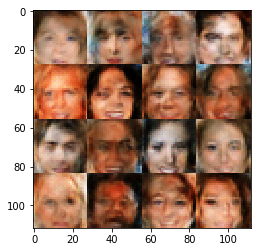

Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 1.0557
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 1.0222
Epoch 1/1... Discriminator Loss: 1.0281... Generator Loss: 1.0362
Epoch 1/1... Discriminator Loss: 0.9580... Generator Loss: 1.2953
Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 1.0148
Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 1.1125
Epoch 1/1... Discriminator Loss: 0.9493... Generator Loss: 1.0584
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 1.2468
Epoch 1/1... Discriminator Loss: 1.0813... Generator Loss: 1.3170
Epoch 1/1... Discriminator Loss: 0.9777... Generator Loss: 1.1243


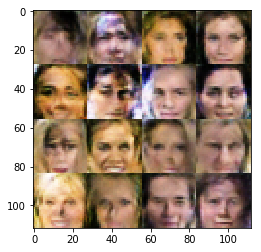

Epoch 1/1... Discriminator Loss: 0.9510... Generator Loss: 1.2989
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.9987
Epoch 1/1... Discriminator Loss: 0.8894... Generator Loss: 1.0575
Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 1.0175
Epoch 1/1... Discriminator Loss: 1.0068... Generator Loss: 1.2252
Epoch 1/1... Discriminator Loss: 0.8665... Generator Loss: 1.2880
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 1.0438
Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 1.1472
Epoch 1/1... Discriminator Loss: 1.0417... Generator Loss: 1.1822
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 1.0826


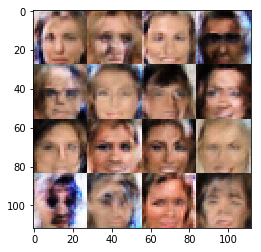

Epoch 1/1... Discriminator Loss: 0.9958... Generator Loss: 1.0660
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 0.9349
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 1.1612
Epoch 1/1... Discriminator Loss: 1.0853... Generator Loss: 1.3376
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 1.2222
Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 0.9472
Epoch 1/1... Discriminator Loss: 0.8768... Generator Loss: 1.4918
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 0.9410
Epoch 1/1... Discriminator Loss: 0.8213... Generator Loss: 1.5163
Epoch 1/1... Discriminator Loss: 0.9125... Generator Loss: 1.3742


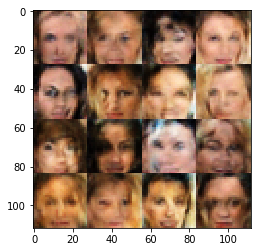

Epoch 1/1... Discriminator Loss: 0.9329... Generator Loss: 1.0490
Epoch 1/1... Discriminator Loss: 0.8894... Generator Loss: 1.4684
Epoch 1/1... Discriminator Loss: 1.1469... Generator Loss: 0.9467
Epoch 1/1... Discriminator Loss: 0.9062... Generator Loss: 1.2028
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 0.9374
Epoch 1/1... Discriminator Loss: 0.9867... Generator Loss: 1.1316
Epoch 1/1... Discriminator Loss: 1.0571... Generator Loss: 1.2124
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 1.2838
Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 1.4300
Epoch 1/1... Discriminator Loss: 1.1059... Generator Loss: 1.2093


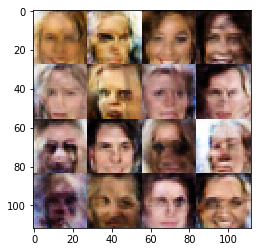

Epoch 1/1... Discriminator Loss: 0.9565... Generator Loss: 1.3468
Epoch 1/1... Discriminator Loss: 1.1146... Generator Loss: 1.0983
Epoch 1/1... Discriminator Loss: 1.0585... Generator Loss: 1.0556
Epoch 1/1... Discriminator Loss: 0.8989... Generator Loss: 1.3474
Epoch 1/1... Discriminator Loss: 0.9363... Generator Loss: 1.3383
Epoch 1/1... Discriminator Loss: 1.1504... Generator Loss: 0.9046
Epoch 1/1... Discriminator Loss: 1.0066... Generator Loss: 1.1949
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.1792... Generator Loss: 0.9391
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 0.8664


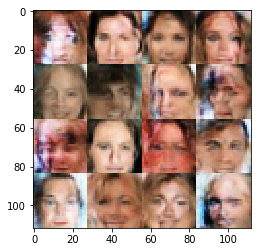

Epoch 1/1... Discriminator Loss: 0.8487... Generator Loss: 1.3380
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 1.1295
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 0.9620
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.8777
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 0.9056
Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 1.0040
Epoch 1/1... Discriminator Loss: 1.1434... Generator Loss: 1.1589
Epoch 1/1... Discriminator Loss: 0.9730... Generator Loss: 1.2795
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 1.1868


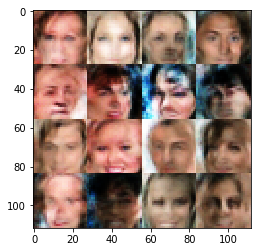

Epoch 1/1... Discriminator Loss: 0.9486... Generator Loss: 1.1903
Epoch 1/1... Discriminator Loss: 0.9497... Generator Loss: 1.2143
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 0.8722
Epoch 1/1... Discriminator Loss: 1.0916... Generator Loss: 1.2871
Epoch 1/1... Discriminator Loss: 0.8514... Generator Loss: 1.2994
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 1.0865
Epoch 1/1... Discriminator Loss: 1.0006... Generator Loss: 0.9910
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 1.2106
Epoch 1/1... Discriminator Loss: 0.9816... Generator Loss: 1.2604
Epoch 1/1... Discriminator Loss: 1.1265... Generator Loss: 1.0614


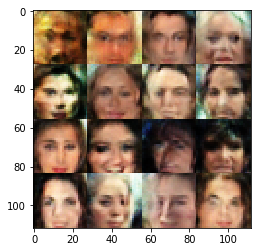

Epoch 1/1... Discriminator Loss: 1.0378... Generator Loss: 1.3241
Epoch 1/1... Discriminator Loss: 1.2374... Generator Loss: 0.9003
Epoch 1/1... Discriminator Loss: 1.0362... Generator Loss: 1.2318
Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 1.2983
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 1.1551
Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 1.2211
Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 1.2719
Epoch 1/1... Discriminator Loss: 0.9506... Generator Loss: 1.2563
Epoch 1/1... Discriminator Loss: 1.1415... Generator Loss: 0.9943


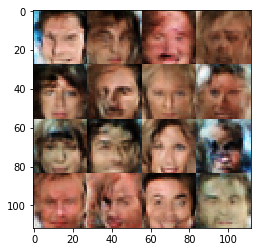

Epoch 1/1... Discriminator Loss: 0.9303... Generator Loss: 1.0133
Epoch 1/1... Discriminator Loss: 0.8527... Generator Loss: 1.1793
Epoch 1/1... Discriminator Loss: 0.9657... Generator Loss: 1.1934
Epoch 1/1... Discriminator Loss: 1.0120... Generator Loss: 1.2517
Epoch 1/1... Discriminator Loss: 0.9820... Generator Loss: 0.9345
Epoch 1/1... Discriminator Loss: 1.0535... Generator Loss: 1.1276
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 1.1672
Epoch 1/1... Discriminator Loss: 1.0023... Generator Loss: 1.1209
Epoch 1/1... Discriminator Loss: 0.9795... Generator Loss: 1.2991
Epoch 1/1... Discriminator Loss: 0.9806... Generator Loss: 1.2170


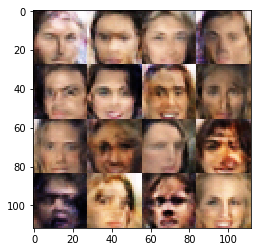

Epoch 1/1... Discriminator Loss: 1.0655... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 0.9780... Generator Loss: 1.2476
Epoch 1/1... Discriminator Loss: 0.9055... Generator Loss: 1.4226
Epoch 1/1... Discriminator Loss: 0.9749... Generator Loss: 1.2440
Epoch 1/1... Discriminator Loss: 0.8826... Generator Loss: 1.3777
Epoch 1/1... Discriminator Loss: 0.9692... Generator Loss: 1.1141
Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 0.9736
Epoch 1/1... Discriminator Loss: 0.9610... Generator Loss: 1.4298
Epoch 1/1... Discriminator Loss: 0.9219... Generator Loss: 1.3149
Epoch 1/1... Discriminator Loss: 1.1813... Generator Loss: 0.9907


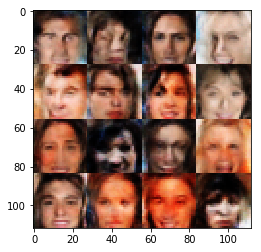

Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 1.1512
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.0324... Generator Loss: 0.9882
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 1.1912
Epoch 1/1... Discriminator Loss: 0.9216... Generator Loss: 0.9885
Epoch 1/1... Discriminator Loss: 1.1296... Generator Loss: 1.1093
Epoch 1/1... Discriminator Loss: 1.0358... Generator Loss: 1.0882
Epoch 1/1... Discriminator Loss: 1.0082... Generator Loss: 1.4404
Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 1.0795
Epoch 1/1... Discriminator Loss: 1.0864... Generator Loss: 0.8737


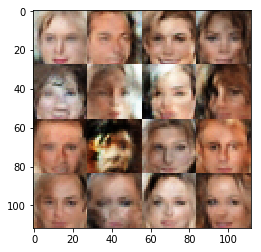

Epoch 1/1... Discriminator Loss: 0.8564... Generator Loss: 1.4721
Epoch 1/1... Discriminator Loss: 1.1557... Generator Loss: 1.2988
Epoch 1/1... Discriminator Loss: 1.0201... Generator Loss: 1.0027
Epoch 1/1... Discriminator Loss: 0.9925... Generator Loss: 0.9272
Epoch 1/1... Discriminator Loss: 0.9447... Generator Loss: 1.4062
Epoch 1/1... Discriminator Loss: 1.0083... Generator Loss: 0.9609
Epoch 1/1... Discriminator Loss: 0.9833... Generator Loss: 1.4528
Epoch 1/1... Discriminator Loss: 0.9317... Generator Loss: 1.1905
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 0.8720... Generator Loss: 1.5922


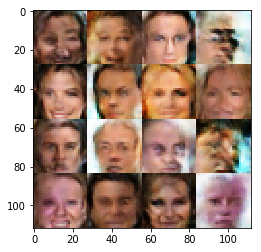

Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 1.2546
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 1.1652
Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 0.9571
Epoch 1/1... Discriminator Loss: 0.9779... Generator Loss: 0.8670
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 1.2589
Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 0.9838
Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 1.1867
Epoch 1/1... Discriminator Loss: 0.9839... Generator Loss: 1.4098
Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 1.3597
Epoch 1/1... Discriminator Loss: 0.9816... Generator Loss: 1.3441


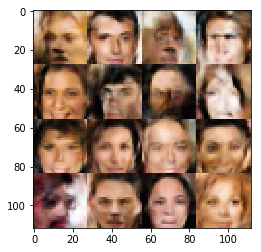

Epoch 1/1... Discriminator Loss: 0.8223... Generator Loss: 1.3323
Epoch 1/1... Discriminator Loss: 0.9077... Generator Loss: 1.3548
Epoch 1/1... Discriminator Loss: 0.9715... Generator Loss: 1.1392
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 1.1585
Epoch 1/1... Discriminator Loss: 0.9011... Generator Loss: 1.2493
Epoch 1/1... Discriminator Loss: 0.7951... Generator Loss: 1.3812
Epoch 1/1... Discriminator Loss: 0.9829... Generator Loss: 1.1808
Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 1.1033
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.0770... Generator Loss: 1.1088


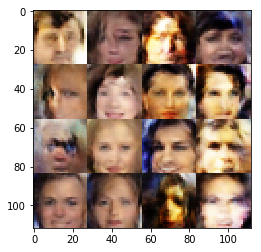

Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 0.9573... Generator Loss: 1.2381
Epoch 1/1... Discriminator Loss: 0.9554... Generator Loss: 1.2877
Epoch 1/1... Discriminator Loss: 1.0600... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 0.9806
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 1.3525
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 0.9813
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 0.9823
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.0060... Generator Loss: 1.0988


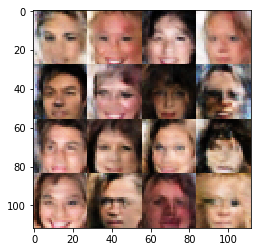

Epoch 1/1... Discriminator Loss: 0.9430... Generator Loss: 1.5920
Epoch 1/1... Discriminator Loss: 0.9528... Generator Loss: 1.3778
Epoch 1/1... Discriminator Loss: 1.1427... Generator Loss: 1.0557
Epoch 1/1... Discriminator Loss: 0.9660... Generator Loss: 0.9558
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 1.1985
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.8896
Epoch 1/1... Discriminator Loss: 0.9658... Generator Loss: 1.0953
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 1.3506
Epoch 1/1... Discriminator Loss: 0.9383... Generator Loss: 1.4260
Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 0.9132


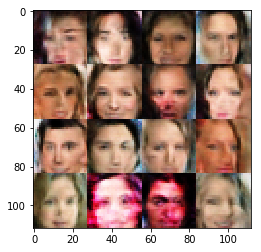

Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 0.9053
Epoch 1/1... Discriminator Loss: 0.9639... Generator Loss: 1.0183
Epoch 1/1... Discriminator Loss: 0.7731... Generator Loss: 1.5003
Epoch 1/1... Discriminator Loss: 1.0623... Generator Loss: 1.1386
Epoch 1/1... Discriminator Loss: 1.0123... Generator Loss: 1.0740
Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 0.8484
Epoch 1/1... Discriminator Loss: 1.0230... Generator Loss: 1.1889
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 0.9661
Epoch 1/1... Discriminator Loss: 0.9537... Generator Loss: 1.3481
Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 0.9028


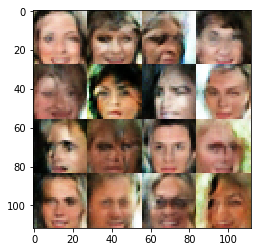

Epoch 1/1... Discriminator Loss: 0.9734... Generator Loss: 1.5475
Epoch 1/1... Discriminator Loss: 0.8348... Generator Loss: 1.3870
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 1.1383
Epoch 1/1... Discriminator Loss: 0.9501... Generator Loss: 1.0882
Epoch 1/1... Discriminator Loss: 1.0135... Generator Loss: 1.1621
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 0.8948
Epoch 1/1... Discriminator Loss: 0.9773... Generator Loss: 1.5769
Epoch 1/1... Discriminator Loss: 1.0646... Generator Loss: 1.2154
Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 1.2285
Epoch 1/1... Discriminator Loss: 0.9432... Generator Loss: 1.6885


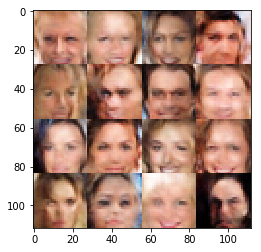

Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 0.9646
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 0.9514
Epoch 1/1... Discriminator Loss: 1.1547... Generator Loss: 1.4043
Epoch 1/1... Discriminator Loss: 0.8573... Generator Loss: 1.3336
Epoch 1/1... Discriminator Loss: 1.0115... Generator Loss: 0.9867
Epoch 1/1... Discriminator Loss: 0.9783... Generator Loss: 1.7420
Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 1.3968
Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 1.1067
Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 1.0746
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 1.2083


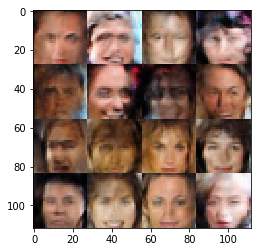

Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 1.1309
Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 1.1692
Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 1.0345
Epoch 1/1... Discriminator Loss: 1.0396... Generator Loss: 1.2664
Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 1.2099
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 1.0309
Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 0.9868
Epoch 1/1... Discriminator Loss: 0.9055... Generator Loss: 1.2319
Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 1.1089
Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 1.4335


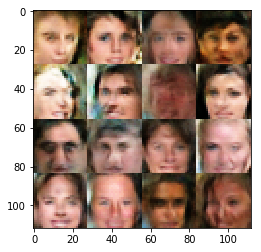

Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 1.0296
Epoch 1/1... Discriminator Loss: 0.9726... Generator Loss: 1.0696
Epoch 1/1... Discriminator Loss: 1.0422... Generator Loss: 1.4879
Epoch 1/1... Discriminator Loss: 0.8900... Generator Loss: 1.2364
Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 1.1121
Epoch 1/1... Discriminator Loss: 1.0777... Generator Loss: 1.3879
Epoch 1/1... Discriminator Loss: 1.0509... Generator Loss: 1.1862
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 1.3235
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 1.1980
Epoch 1/1... Discriminator Loss: 1.0016... Generator Loss: 0.9559


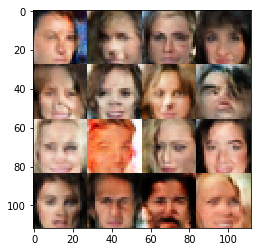

Epoch 1/1... Discriminator Loss: 1.0010... Generator Loss: 1.4396
Epoch 1/1... Discriminator Loss: 0.9963... Generator Loss: 1.3870
Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 1.4026
Epoch 1/1... Discriminator Loss: 0.9936... Generator Loss: 1.2738
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.9453
Epoch 1/1... Discriminator Loss: 1.0177... Generator Loss: 1.4797
Epoch 1/1... Discriminator Loss: 1.1361... Generator Loss: 0.8987
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 1.0987
Epoch 1/1... Discriminator Loss: 1.1379... Generator Loss: 1.0353
Epoch 1/1... Discriminator Loss: 0.9858... Generator Loss: 1.2684


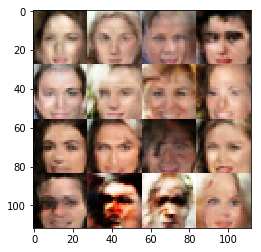

Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 1.2470
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 1.1458
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 1.1430
Epoch 1/1... Discriminator Loss: 0.9486... Generator Loss: 1.6376
Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 1.5173
Epoch 1/1... Discriminator Loss: 0.9214... Generator Loss: 1.3770
Epoch 1/1... Discriminator Loss: 0.8732... Generator Loss: 1.2307
Epoch 1/1... Discriminator Loss: 1.0449... Generator Loss: 1.0586
Epoch 1/1... Discriminator Loss: 0.9272... Generator Loss: 1.1708
Epoch 1/1... Discriminator Loss: 1.0325... Generator Loss: 1.3261


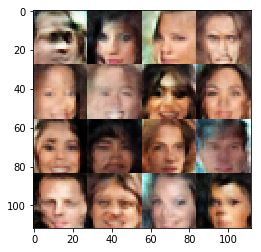

Epoch 1/1... Discriminator Loss: 1.0217... Generator Loss: 1.4681
Epoch 1/1... Discriminator Loss: 0.9284... Generator Loss: 1.1884
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 1.1681
Epoch 1/1... Discriminator Loss: 1.0117... Generator Loss: 1.0699
Epoch 1/1... Discriminator Loss: 1.0322... Generator Loss: 1.0271
Epoch 1/1... Discriminator Loss: 1.0026... Generator Loss: 1.2365
Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 0.9744
Epoch 1/1... Discriminator Loss: 1.0157... Generator Loss: 1.1869
Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 1.3100
Epoch 1/1... Discriminator Loss: 1.0500... Generator Loss: 1.3879


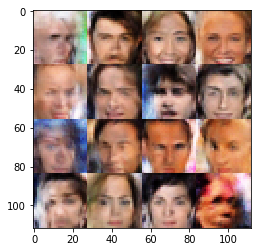

Epoch 1/1... Discriminator Loss: 1.0042... Generator Loss: 1.1914
Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 1.1974
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 1.3434
Epoch 1/1... Discriminator Loss: 1.0006... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 0.9314... Generator Loss: 1.2132
Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 1.3825
Epoch 1/1... Discriminator Loss: 1.1730... Generator Loss: 0.9175
Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 1.1198
Epoch 1/1... Discriminator Loss: 1.0899... Generator Loss: 1.3577
Epoch 1/1... Discriminator Loss: 1.1095... Generator Loss: 1.3268


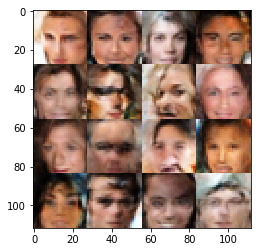

Epoch 1/1... Discriminator Loss: 0.8796... Generator Loss: 1.0460
Epoch 1/1... Discriminator Loss: 0.9073... Generator Loss: 1.2315
Epoch 1/1... Discriminator Loss: 1.1704... Generator Loss: 1.0728
Epoch 1/1... Discriminator Loss: 0.9993... Generator Loss: 1.1332
Epoch 1/1... Discriminator Loss: 1.0013... Generator Loss: 1.4024
Epoch 1/1... Discriminator Loss: 1.0429... Generator Loss: 1.3645
Epoch 1/1... Discriminator Loss: 0.9511... Generator Loss: 1.3406
Epoch 1/1... Discriminator Loss: 0.9626... Generator Loss: 0.9087
Epoch 1/1... Discriminator Loss: 0.9508... Generator Loss: 1.6060
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 1.1608


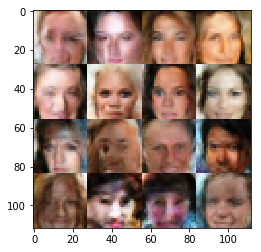

Epoch 1/1... Discriminator Loss: 1.1036... Generator Loss: 1.1599
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 1.0528
Epoch 1/1... Discriminator Loss: 0.9344... Generator Loss: 1.2143
Epoch 1/1... Discriminator Loss: 1.0124... Generator Loss: 1.0371
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 1.0952
Epoch 1/1... Discriminator Loss: 0.9799... Generator Loss: 1.0355
Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 1.3010
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 0.9700
Epoch 1/1... Discriminator Loss: 0.8844... Generator Loss: 1.4299


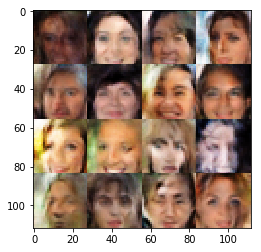

Epoch 1/1... Discriminator Loss: 1.1797... Generator Loss: 1.0906
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 0.8744
Epoch 1/1... Discriminator Loss: 1.1111... Generator Loss: 1.0502
Epoch 1/1... Discriminator Loss: 0.9915... Generator Loss: 1.1840
Epoch 1/1... Discriminator Loss: 0.8047... Generator Loss: 1.2589
Epoch 1/1... Discriminator Loss: 1.0277... Generator Loss: 1.2374
Epoch 1/1... Discriminator Loss: 1.0623... Generator Loss: 1.1278
Epoch 1/1... Discriminator Loss: 1.0452... Generator Loss: 0.8770
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 1.3530
Epoch 1/1... Discriminator Loss: 0.9547... Generator Loss: 1.3191


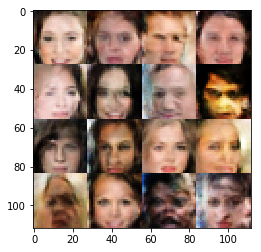

Epoch 1/1... Discriminator Loss: 0.9460... Generator Loss: 1.2257
Epoch 1/1... Discriminator Loss: 0.9860... Generator Loss: 1.3186
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 1.2403
Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 1.4272
Epoch 1/1... Discriminator Loss: 1.0294... Generator Loss: 1.5169
Epoch 1/1... Discriminator Loss: 0.8821... Generator Loss: 1.2024
Epoch 1/1... Discriminator Loss: 1.0429... Generator Loss: 1.1168
Epoch 1/1... Discriminator Loss: 0.9889... Generator Loss: 1.0951
Epoch 1/1... Discriminator Loss: 0.8422... Generator Loss: 1.4177


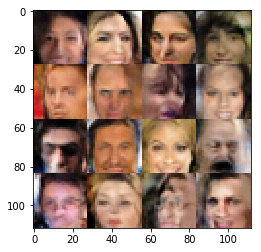

Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 1.0134
Epoch 1/1... Discriminator Loss: 0.9926... Generator Loss: 1.0702
Epoch 1/1... Discriminator Loss: 0.8885... Generator Loss: 1.0832
Epoch 1/1... Discriminator Loss: 1.0215... Generator Loss: 1.2280
Epoch 1/1... Discriminator Loss: 0.9666... Generator Loss: 1.1050
Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 1.0589
Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 1.1935
Epoch 1/1... Discriminator Loss: 0.8587... Generator Loss: 1.3610
Epoch 1/1... Discriminator Loss: 1.0610... Generator Loss: 1.1373
Epoch 1/1... Discriminator Loss: 0.9446... Generator Loss: 1.2628


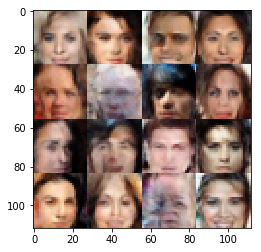

Epoch 1/1... Discriminator Loss: 0.8225... Generator Loss: 1.0129
Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 0.8868... Generator Loss: 1.5199
Epoch 1/1... Discriminator Loss: 1.0006... Generator Loss: 1.5135
Epoch 1/1... Discriminator Loss: 1.0175... Generator Loss: 1.2417
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 1.0022
Epoch 1/1... Discriminator Loss: 1.0991... Generator Loss: 1.5521
Epoch 1/1... Discriminator Loss: 0.9007... Generator Loss: 1.3216
Epoch 1/1... Discriminator Loss: 0.9260... Generator Loss: 1.3192
Epoch 1/1... Discriminator Loss: 0.9168... Generator Loss: 1.2608


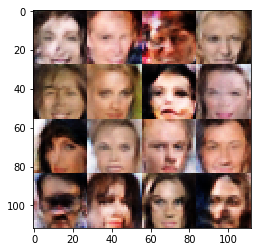

Epoch 1/1... Discriminator Loss: 0.8771... Generator Loss: 1.1680
Epoch 1/1... Discriminator Loss: 0.9367... Generator Loss: 1.0351
Epoch 1/1... Discriminator Loss: 1.0380... Generator Loss: 1.3637
Epoch 1/1... Discriminator Loss: 0.9458... Generator Loss: 1.0516
Epoch 1/1... Discriminator Loss: 0.9684... Generator Loss: 1.2482
Epoch 1/1... Discriminator Loss: 1.0894... Generator Loss: 1.0752
Epoch 1/1... Discriminator Loss: 0.8155... Generator Loss: 1.2501
Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 1.6172
Epoch 1/1... Discriminator Loss: 1.0102... Generator Loss: 1.0319
Epoch 1/1... Discriminator Loss: 1.0443... Generator Loss: 1.3485


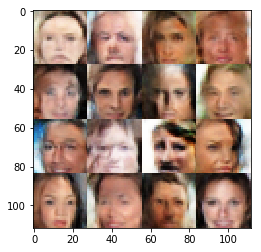

Epoch 1/1... Discriminator Loss: 0.9743... Generator Loss: 1.3329
Epoch 1/1... Discriminator Loss: 1.0633... Generator Loss: 1.4277
Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 1.2632
Epoch 1/1... Discriminator Loss: 1.0644... Generator Loss: 1.1966
Epoch 1/1... Discriminator Loss: 0.9908... Generator Loss: 1.2506
Epoch 1/1... Discriminator Loss: 0.9943... Generator Loss: 1.2349
Epoch 1/1... Discriminator Loss: 0.9136... Generator Loss: 1.3087
Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 1.1402
Epoch 1/1... Discriminator Loss: 0.9418... Generator Loss: 1.2600
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 1.0361


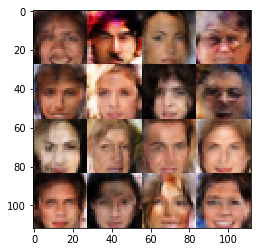

Epoch 1/1... Discriminator Loss: 0.9600... Generator Loss: 1.3761
Epoch 1/1... Discriminator Loss: 0.8520... Generator Loss: 1.1410
Epoch 1/1... Discriminator Loss: 0.8954... Generator Loss: 1.6653
Epoch 1/1... Discriminator Loss: 0.8752... Generator Loss: 1.3187
Epoch 1/1... Discriminator Loss: 0.8629... Generator Loss: 1.4374
Epoch 1/1... Discriminator Loss: 1.0944... Generator Loss: 1.1802
Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 1.4511
Epoch 1/1... Discriminator Loss: 0.9537... Generator Loss: 1.1212
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 1.1121
Epoch 1/1... Discriminator Loss: 0.9397... Generator Loss: 1.3068


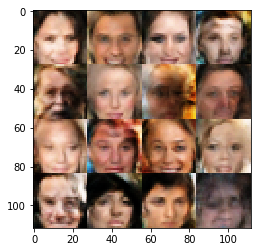

Epoch 1/1... Discriminator Loss: 0.8049... Generator Loss: 1.2159
Epoch 1/1... Discriminator Loss: 0.9702... Generator Loss: 1.0132
Epoch 1/1... Discriminator Loss: 0.8944... Generator Loss: 1.4354
Epoch 1/1... Discriminator Loss: 1.0135... Generator Loss: 1.1698
Epoch 1/1... Discriminator Loss: 0.8617... Generator Loss: 1.1187
Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 1.1562
Epoch 1/1... Discriminator Loss: 0.8652... Generator Loss: 1.4658
Epoch 1/1... Discriminator Loss: 1.0533... Generator Loss: 1.0862
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 1.2619
Epoch 1/1... Discriminator Loss: 1.0276... Generator Loss: 1.1411


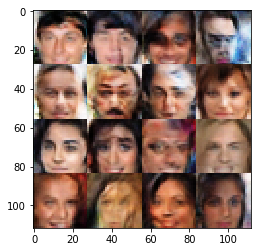

Epoch 1/1... Discriminator Loss: 0.8677... Generator Loss: 1.4111
Epoch 1/1... Discriminator Loss: 1.0688... Generator Loss: 0.9790
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 0.9462
Epoch 1/1... Discriminator Loss: 0.9335... Generator Loss: 1.0175
Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 1.1570
Epoch 1/1... Discriminator Loss: 0.8541... Generator Loss: 1.2391
Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 0.8870... Generator Loss: 1.0879
Epoch 1/1... Discriminator Loss: 0.9699... Generator Loss: 1.3863
Epoch 1/1... Discriminator Loss: 1.0580... Generator Loss: 1.3675


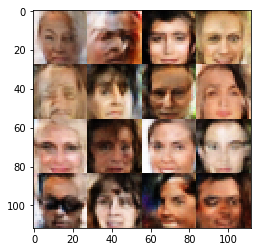

Epoch 1/1... Discriminator Loss: 1.0125... Generator Loss: 1.0719
Epoch 1/1... Discriminator Loss: 0.9448... Generator Loss: 1.2232
Epoch 1/1... Discriminator Loss: 0.9010... Generator Loss: 1.3041
Epoch 1/1... Discriminator Loss: 0.9231... Generator Loss: 1.0014
Epoch 1/1... Discriminator Loss: 0.9155... Generator Loss: 1.3473
Epoch 1/1... Discriminator Loss: 0.9520... Generator Loss: 1.0412
Epoch 1/1... Discriminator Loss: 0.8476... Generator Loss: 1.1749
Epoch 1/1... Discriminator Loss: 0.8673... Generator Loss: 1.0350
Epoch 1/1... Discriminator Loss: 1.0440... Generator Loss: 1.0214
Epoch 1/1... Discriminator Loss: 0.8859... Generator Loss: 1.3775


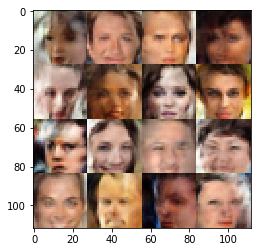

Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 1.2072
Epoch 1/1... Discriminator Loss: 0.8231... Generator Loss: 1.3202
Epoch 1/1... Discriminator Loss: 0.8839... Generator Loss: 1.3444
Epoch 1/1... Discriminator Loss: 0.8747... Generator Loss: 1.5174
Epoch 1/1... Discriminator Loss: 0.9887... Generator Loss: 1.4331
Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 1.0319
Epoch 1/1... Discriminator Loss: 1.0196... Generator Loss: 1.2586
Epoch 1/1... Discriminator Loss: 0.9090... Generator Loss: 1.2293
Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 1.4010


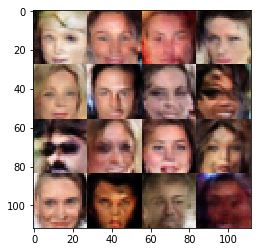

Epoch 1/1... Discriminator Loss: 0.9296... Generator Loss: 1.5488
Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 0.9572
Epoch 1/1... Discriminator Loss: 0.9540... Generator Loss: 0.8937
Epoch 1/1... Discriminator Loss: 0.9976... Generator Loss: 0.9600
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 1.0587
Epoch 1/1... Discriminator Loss: 1.0079... Generator Loss: 1.0293
Epoch 1/1... Discriminator Loss: 1.0626... Generator Loss: 1.1260
Epoch 1/1... Discriminator Loss: 0.9983... Generator Loss: 1.4783
Epoch 1/1... Discriminator Loss: 0.7517... Generator Loss: 1.6349
Epoch 1/1... Discriminator Loss: 0.9833... Generator Loss: 1.0202


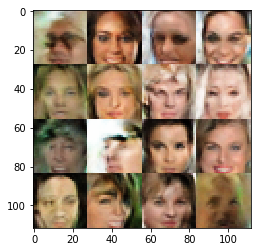

Epoch 1/1... Discriminator Loss: 1.0761... Generator Loss: 1.3677
Epoch 1/1... Discriminator Loss: 0.7977... Generator Loss: 1.0405
Epoch 1/1... Discriminator Loss: 0.8287... Generator Loss: 1.3012
Epoch 1/1... Discriminator Loss: 0.8831... Generator Loss: 1.4833
Epoch 1/1... Discriminator Loss: 0.9132... Generator Loss: 1.1962
Epoch 1/1... Discriminator Loss: 0.8764... Generator Loss: 1.3722
Epoch 1/1... Discriminator Loss: 0.8943... Generator Loss: 1.2964
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 1.2864
Epoch 1/1... Discriminator Loss: 0.8718... Generator Loss: 1.2640
Epoch 1/1... Discriminator Loss: 0.8515... Generator Loss: 1.3551


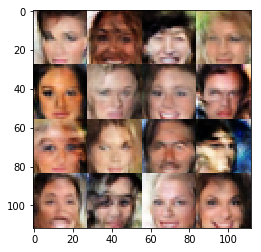

Epoch 1/1... Discriminator Loss: 0.9486... Generator Loss: 1.1464
Epoch 1/1... Discriminator Loss: 0.8759... Generator Loss: 1.3349
Epoch 1/1... Discriminator Loss: 1.0683... Generator Loss: 1.3457
Epoch 1/1... Discriminator Loss: 1.0456... Generator Loss: 1.2336
Epoch 1/1... Discriminator Loss: 0.8277... Generator Loss: 1.4541
Epoch 1/1... Discriminator Loss: 0.9671... Generator Loss: 1.4743
Epoch 1/1... Discriminator Loss: 1.0254... Generator Loss: 1.3001
Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 1.3563
Epoch 1/1... Discriminator Loss: 1.0208... Generator Loss: 1.2596
Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 1.3867


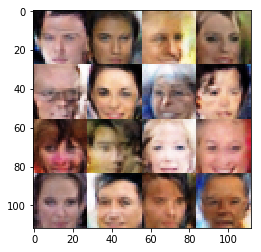

Epoch 1/1... Discriminator Loss: 0.9562... Generator Loss: 1.2707
Epoch 1/1... Discriminator Loss: 0.7745... Generator Loss: 1.6373
Epoch 1/1... Discriminator Loss: 0.9403... Generator Loss: 1.5114
Epoch 1/1... Discriminator Loss: 0.8296... Generator Loss: 1.2937
Epoch 1/1... Discriminator Loss: 0.9771... Generator Loss: 1.3580
Epoch 1/1... Discriminator Loss: 1.0954... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 0.9764... Generator Loss: 1.2772
Epoch 1/1... Discriminator Loss: 0.9920... Generator Loss: 1.0193
Epoch 1/1... Discriminator Loss: 0.8657... Generator Loss: 1.1365
Epoch 1/1... Discriminator Loss: 1.0083... Generator Loss: 1.1434


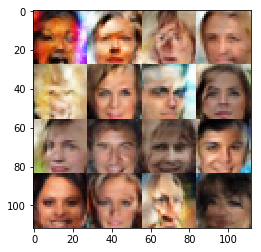

Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 0.9475
Epoch 1/1... Discriminator Loss: 0.8521... Generator Loss: 1.1831
Epoch 1/1... Discriminator Loss: 0.9332... Generator Loss: 1.3003
Epoch 1/1... Discriminator Loss: 0.8451... Generator Loss: 1.2995
Epoch 1/1... Discriminator Loss: 0.9838... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.0722... Generator Loss: 1.1682
Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 1.3810
Epoch 1/1... Discriminator Loss: 0.8404... Generator Loss: 1.2434
Epoch 1/1... Discriminator Loss: 0.8357... Generator Loss: 1.5015
Epoch 1/1... Discriminator Loss: 0.8490... Generator Loss: 1.5081


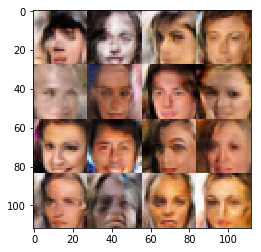

Epoch 1/1... Discriminator Loss: 0.8769... Generator Loss: 1.2501
Epoch 1/1... Discriminator Loss: 0.9796... Generator Loss: 1.6494
Epoch 1/1... Discriminator Loss: 0.8448... Generator Loss: 1.3651
Epoch 1/1... Discriminator Loss: 0.8519... Generator Loss: 1.1946
Epoch 1/1... Discriminator Loss: 0.8943... Generator Loss: 1.3779
Epoch 1/1... Discriminator Loss: 0.8939... Generator Loss: 1.3722
Epoch 1/1... Discriminator Loss: 0.8586... Generator Loss: 1.6094
Epoch 1/1... Discriminator Loss: 0.8718... Generator Loss: 1.4496
Epoch 1/1... Discriminator Loss: 0.9277... Generator Loss: 1.4358
Epoch 1/1... Discriminator Loss: 0.9259... Generator Loss: 1.5209


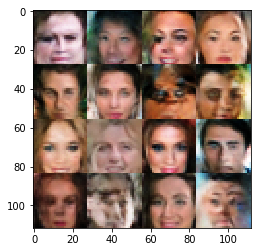

Epoch 1/1... Discriminator Loss: 0.8986... Generator Loss: 1.4724
Epoch 1/1... Discriminator Loss: 0.9359... Generator Loss: 1.3453
Epoch 1/1... Discriminator Loss: 0.9343... Generator Loss: 1.1902
Epoch 1/1... Discriminator Loss: 0.9208... Generator Loss: 1.1017
Epoch 1/1... Discriminator Loss: 0.8015... Generator Loss: 1.3785
Epoch 1/1... Discriminator Loss: 0.9396... Generator Loss: 1.3894
Epoch 1/1... Discriminator Loss: 0.9678... Generator Loss: 1.4967
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 1.1930
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 1.2300
Epoch 1/1... Discriminator Loss: 1.0146... Generator Loss: 0.9945


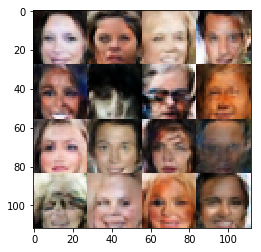

Epoch 1/1... Discriminator Loss: 0.7655... Generator Loss: 1.2541
Epoch 1/1... Discriminator Loss: 0.8408... Generator Loss: 1.4774
Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 1.4027
Epoch 1/1... Discriminator Loss: 0.8846... Generator Loss: 1.5764
Epoch 1/1... Discriminator Loss: 0.9381... Generator Loss: 1.6445
Epoch 1/1... Discriminator Loss: 0.9632... Generator Loss: 1.0400
Epoch 1/1... Discriminator Loss: 0.9689... Generator Loss: 1.5701
Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 1.1481
Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 1.3095
Epoch 1/1... Discriminator Loss: 1.1264... Generator Loss: 0.8982


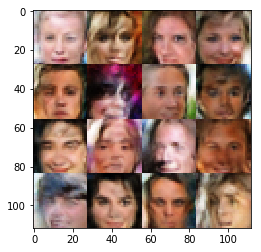

Epoch 1/1... Discriminator Loss: 0.7753... Generator Loss: 1.4362
Epoch 1/1... Discriminator Loss: 0.9341... Generator Loss: 1.6205
Epoch 1/1... Discriminator Loss: 0.9516... Generator Loss: 1.4020
Epoch 1/1... Discriminator Loss: 0.9843... Generator Loss: 1.3668


In [20]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.